In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [60]:
# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

colors = [color_0, color_1]
colors_light = [color_0_light,color_1_light]

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [61]:
margin=-0.1
df = pd.read_csv(f'experiments/M_{margin}_data.csv')
df = df[df['M'] == 256]
sep = 'separable' if margin > 0 else 'overlap'
shots = [4,8,16,32,64,128,256,512,1024,2048,4096, 8192] 
shots.sort()

In [62]:
shots

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

100
[[2.47897568 2.9649606  2.23514738 1.1975434  1.58948839 1.12992909
  0.63657051 0.62590968 0.19913536 0.3094695  0.47609306 0.18483869]
 [2.0303773  2.68728324 2.45517259 0.8707197  1.76022082 1.06453893
  0.69168099 0.48725547 0.20977308 0.37218524 0.43655172 0.21209059]]
[-1.79287983  9.09904099]
100
[[365.16084204 187.62918638 267.74530094 273.89608491 164.85725939
  107.99854897  90.06798567  28.73557133 101.16286239  56.24638932
    6.42079585   3.75859552]
 [375.51065835 177.51072634 316.13173546 236.51562565 177.3833483
  101.8862466   85.42014794  27.22463041  92.21677091  54.35137955
    6.52775288   3.41935915]]
[-1.13651004 12.54351523]


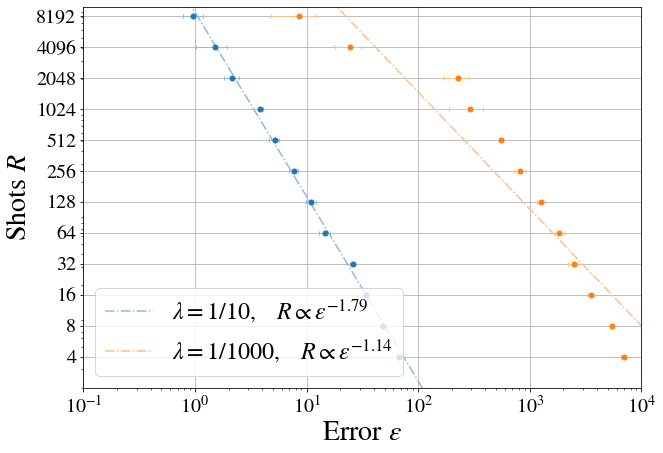

In [63]:
plt.figure(figsize=(10,7))
for i, C in enumerate([10.,1000.]):
    filter = df['C'] == C
    print(np.sum(filter))
    epsilons = np.array([df['epsilon'][(df['R'] == R) & filter ] for R in shots])
    means = np.mean(epsilons,axis=1)
    upper = np.quantile(epsilons, upper_percentile, axis=1)
    lower = np.quantile(epsilons,lower_percentile,axis=1)
    errors = np.array([means - lower, upper - means])
    print(errors)
    plt.errorbar(means,shots,xerr=errors,marker='.',ecolor=colors_light[i],elinewidth=1.,ls='',capsize=2,
        color=colors[i], ms=10)
    #plt.scatter(means,shots,c=colors[i])
    #plt.errorbar(means,shots,xerr=stds,fmt='.')
    plt.xscale('log')
    plt.yscale('log')
    p = np.polyfit(np.log(means),np.log(shots),1)
    print(p)
    efine = np.geomspace(0.0001,1e4,1000)
    plt.plot(efine,np.exp(p[1])*efine**(p[0]),linestyle='-.',label=r'$\lambda = 1/{{%s}},\quad R\propto\varepsilon^{{%.2f}}$'%(int(C),p[0]),color=colors_light[i])

plt.yticks(shots,shots)
plt.xlim(1e-1,1e4)
plt.ylim(2,1e4)
plt.xlabel(r'Error $\varepsilon$')
plt.ylabel(r'Shots $R$')
plt.grid()
plt.legend(loc='lower left')
plt.savefig(f'plots/dual_exponent_{sep}.png',dpi=300,bbox_inches='tight')